# Image Classification with Logistic Regression

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

tf.get_logger().setLevel('INFO')

This notebook demonstrates a basic understanding of using logistic regression in tensorflow for image recognition using the famous MNIST dataset for fashion. Specifically, we will attempt to categorize images as being either sneakers or not sneakers.

In [9]:
# Load the Fashion MNIST dataset.
# load_data() is a func that simultaneously serves up data and abstracts the train-test split
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

---
###  Exploratory Data Analysis (EDA)

### <span style="color:chocolate"></span> Getting to know your data

In [10]:

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print(type(X_train), type(Y_train), type(X_test), type(Y_test))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


### <span style="color:chocolate"></span> Getting to know your data - cont'd

Fashion MNIST images have one of 10 possible labels (shown above).

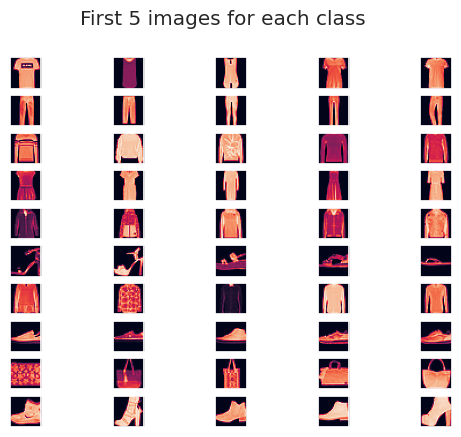

In [11]:

def get_first_five_elements(label: int):
  """
  @label: number representing the class of the fashion item
  returns: list of X_train elements that correspond to the label
  """

  element_indices = np.where(Y_train == label)[:5] #<- list of indices for images with class *label*
  X_data = []
  for index in element_indices:
    X_data.append(X_train[index])
  return X_data

distinct_labels = np.unique(Y_train) #DISTINCT in SQL
f, axarr = plt.subplots(10,5)

for i in range(len(distinct_labels)):
  image_datas = get_first_five_elements(distinct_labels[i])
  for j in range(5):
    axarr[i,j].imshow(image_datas[0][j])


plt.suptitle('First 5 images for each class')
plt.setp(axarr, xticks=[], yticks=[])
plt.show()

### <span style="color:chocolate"></span> Feature preprocessing

In [12]:
# standardize
X_train = X_train/255
X_test = X_test/255
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


### <span style="color:chocolate"></span> Label preprocessing

In [13]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

def encode(class_value):
  return 1 if class_value == 7 else 0

Y_train = np.array(list(map(encode, Y_train)))
Y_test = np.array(list(map(encode, Y_test)))

### <span style="color:chocolate"></span> Data splits

In [14]:
#80-20 train test split
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234)
print(X_train_mini.shape, X_val.shape, Y_train_mini.shape, Y_val.shape)

(48000, 784) (12000, 784) (48000,) (12000,)


### <span style="color:chocolate"></span> Data shuffling

In [15]:
# batching requires equal representation of classes
np.random.seed(0)
shuffled_indices = np.random.permutation(len(X_train_mini))
X_train_mini = X_train_mini[shuffled_indices]
Y_train_mini = Y_train_mini[shuffled_indices]

Before delving into model training, let's further explore the raw feature values by comparing sneaker and non-sneaker training images.

### <span style="color:chocolate"></span> Pixel distributions

Pixel distribution for image classes can be a useful indicator of which classes are mostly likely to be confused during the model training process.

Mean sneaker pixel value 0.1682747275993731


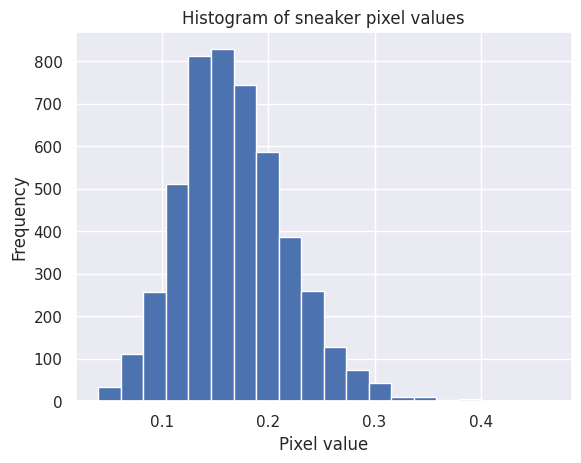

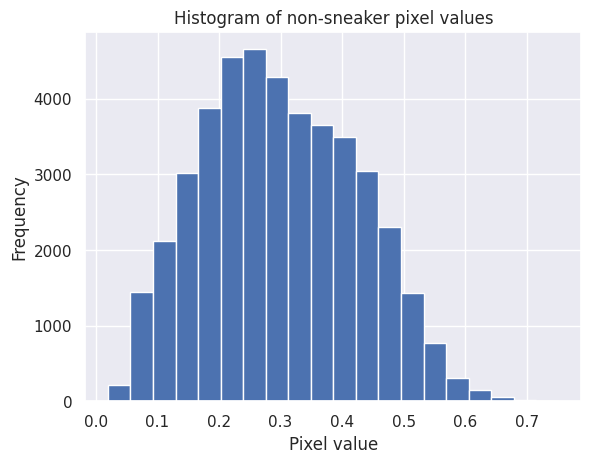

In [18]:

sneaker_indices = np.where(Y_train_mini == 1)
sneaker_images = X_train_mini[sneaker_indices]
sneaker_average_pixel_values = np.mean(sneaker_images, axis=1)
sneaker_mean_pixel_value = np.mean(sneaker_average_pixel_values)
print("Mean sneaker pixel value", sneaker_mean_pixel_value)

# make a histogram of sneaker_average_pixel_values
plt.hist(sneaker_average_pixel_values, bins=20)
plt.title("Histogram of sneaker pixel values")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

non_sneaker_indices = np.where(Y_train_mini == 0)
non_sneaker_images = X_train_mini[non_sneaker_indices]
non_sneaker_average_pixel_values = np.mean(non_sneaker_images, axis=1)
non_sneaker_mean_pixel_value = np.mean(non_sneaker_average_pixel_values)

# make a histogram of non-sneaker average_pixel_values
plt.hist(non_sneaker_average_pixel_values, bins=20)
plt.title("Histogram of non-sneaker pixel values")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()



---
###  Modeling

### <span style="color:chocolate"></span> Baseline model

In [19]:
# use the dominant class (non-sneaker images)
number_of_sneaker_images_train = np.sum(Y_train_mini == 1)
number_of_non_sneaker_images_train = np.sum(Y_train_mini == 0)
majority_class = np.bincount(Y_train_mini).argmax()
accuracy_majority_classifier = number_of_non_sneaker_images_train / len(Y_train_mini)

print("Number of sneaker images in Y_train_mini:", number_of_sneaker_images_train)
print("Number of non-sneaker images in Y_train_mini:", number_of_non_sneaker_images_train)
print("Majority class in Y_train_mini:", majority_class)
print("Accuracy of Majority classifier:", accuracy_majority_classifier)

Number of sneaker images in Y_train_mini: 4800
Number of non-sneaker images in Y_train_mini: 43200
Majority class in Y_train_mini: 0
Accuracy of Majority classifier: 0.9


In [20]:
def __compute_log_loss_terms(y_true, y_pred):
  # optionally add a trivial epislon in terms that would otherwise compute log(0)
  epsilon = 1e-8
  first_term = y_true * np.log(y_pred + (epsilon if y_pred == 0 else 0))
  second_term = (1-y_true) * np.log(1-y_pred + (epsilon if y_pred == 1 else 0))
  return first_term + second_term

def log_loss(y_true, y_pred):
  # iterate over pred / true values simultaneously
  loss_vals = [
      __compute_log_loss_terms(y_true, y_pred)
      for y_true,y_pred
      in zip(y_true, y_pred)
    ]

  return -np.mean(loss_vals)

Y_pred_mini = np.zeros(len(Y_train_mini))
Y_pred_val = np.zeros(len(Y_val))

print(log_loss(Y_train_mini, Y_pred_mini))
print(log_loss(Y_val, Y_pred_val))

1.8420680743952367
1.8420680743952367


### <span style="color:chocolate"></span> Improvement over Baseline with TensorFlow

In [21]:
def build_model(num_features, learning_rate):
  """
  Returns:
    model: A tf.keras model (graph).
  """

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)


  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation=keras.activations.sigmoid,
      kernel_initializer=keras.initializers.Ones()  ,  # initialize params to 1
      bias_initializer=keras.initializers.Ones(),    # initialize bias to 1
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer)

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 208.5961 - val_loss: 199.9825
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 196.0804 - val_loss: 187.4252
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 183.5648 - val_loss: 174.8679
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 171.0492 - val_loss: 162.3107
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 158.5334 - val_loss: 149.7533


Text(0, 0.5, 'Loss (Log-Loss)')

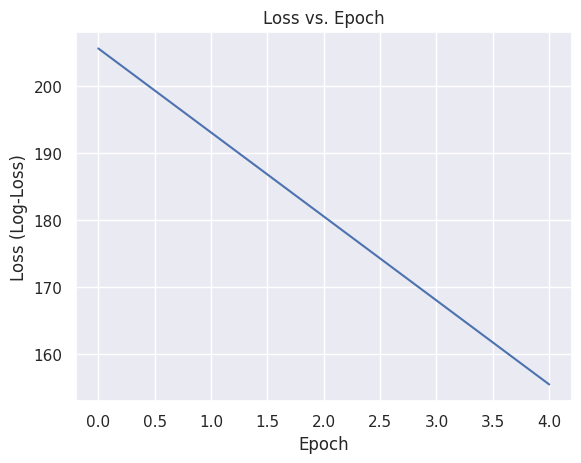

In [22]:
tf.random.set_seed(0)
model_tf = build_model(num_features=X_train_mini.shape[1], learning_rate=0.0001)
#fit
history = model_tf.fit(X_train_mini, Y_train_mini, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

losses = history.history['loss']
epochs = history.epoch
sns.lineplot(y=losses, x=epochs)
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log-Loss)")

---
###  Hyperparameter tuning

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Text(0, 0.5, 'Loss (log-loss)')

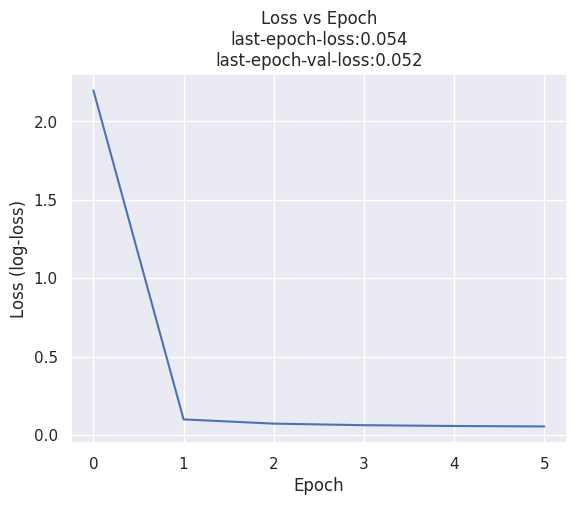

In [23]:
tf.random.set_seed(0)
# 2. Build and compile model
model_tf = build_model(num_features=X_train_mini.shape[1], learning_rate=0.1)

# 3. Fit the model
model_tf_fit = model_tf.fit(X_train_mini, Y_train_mini, epochs=6, validation_data=(X_val, Y_val), verbose=0)

losses = model_tf_fit.history['loss']
val_losses = model_tf_fit.history['val_loss']

losses = [round(l,3) for l in losses]
val_losses = [round(v,3) for v in val_losses]

epochs = model_tf_fit.epoch
sns.lineplot(y=losses, x=epochs)
plt.title(f"Loss vs Epoch\nlast-epoch-loss:{losses[-1]}\nlast-epoch-val-loss:{val_losses[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss (log-loss)")

In [24]:
#percentage diff between losses
diffs = [round((losses[i] - val_losses[i]) / losses[i] * 100, 2) for i in range(len(losses))]
print(diffs)

[94.45, 23.23, 13.89, 8.06, 5.26, 3.7]


[[0.99975014]
 [0.99931943]
 [0.9932929 ]
 [0.98362905]
 [0.95189124]]


Text(0, 0.5, 'Difference (%)')

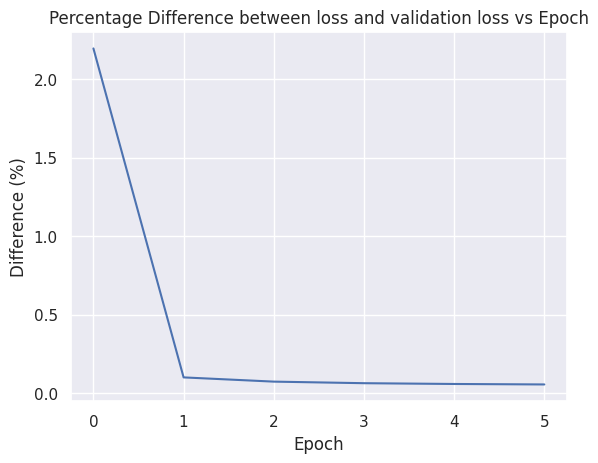

In [25]:
# display first five learned parameters of model_tf_fit
print(model_tf_fit.model.get_weights()[0][:5])
epochs = model_tf_fit.epoch
sns.lineplot(y=losses, x=epochs)
plt.title(f"Percentage Difference between loss and validation loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Difference (%)")

---
###  Evaluation and Generalization

### <span style="color:chocolate"></span> Computing accuracy

In [ ]:
train_accuracy = model_tf.evaluate(X_train_mini, Y_train_mini)
test_accuracy = model_tf.evaluate(X_test, Y_test)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 0.0514
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0532


### <span style="color:chocolate"></span> Fairness evaluation

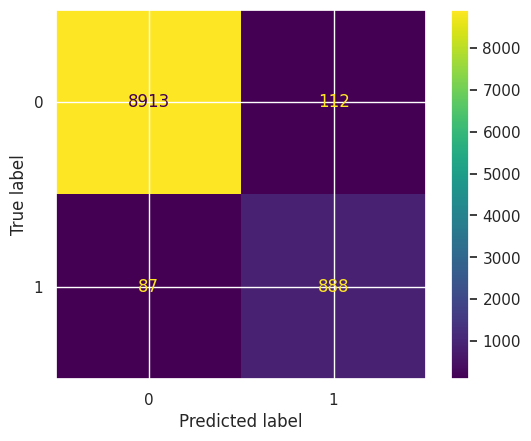

In [ ]:
test_perf_vals = [ 1 if perf >= .5 else 0 for perf in test_perf]
# from left to right: TP, FP, FN, TN
ConfusionMatrixDisplay(confusion_matrix(test_perf_vals, Y_test)).plot()

In [ ]:
# per class accuracy of model_tf
non_sneaker_indices = np.where(Y_test == 0)
sneaker_indices = np.where(Y_test == 1)

non_sneaker_images = X_test[non_sneaker_indices]
sneaker_images = X_test[sneaker_indices]


non_sneaker_perf = model_tf.evaluate(non_sneaker_images, np.zeros(len(non_sneaker_images)))
sneaker_perf = model_tf.evaluate(sneaker_images, np.ones(len(sneaker_images)))

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0254  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3060 
